In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0030.JPEG
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/download (31).jpeg
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0048.jpeg
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0002.JPEG
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/46ba5d744b2d4ce9ac2192cbc340cf56_thb.jpg
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0025.JPEG
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/download (23).jpeg
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0007.JPEG
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0014.JPEG
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/images - 2022-12-12T151418.948.jpeg
/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0005.JPEG
/kaggle/input/car-damage-severity-dataset/dat

## Car Damage Severity Prediction

An excessive amount of money is misspent on unprecedented minor car damages, in today’s age of fraudulent insurance claims. A software based on machine learning and deep learning algorithms can help to solve these kinds of issues for insurance industries. The algorithms are fed the images of damaged cars and it is made to assess its severity. Usually, visual inspection and validation are used to reduce such incidents.
However, in order to lessen the delays in claim processing, the need for an automated system is inherent.
Faster processing can be claimed by automatic car damage detection in the insurance industry. The use of Artificial Intelligence.

Link to the dataset: https://www.kaggle.com/datasets/prajwalbhamere/car-damage-severity-dataset/data

### EDA

In [60]:
# Counting the number of samples per class in train
from collections import Counter

base_path = "/kaggle/input/car-damage-severity-dataset/data3a/training"

class_counts = {}

for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    # if path exists
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

class_counts

{'03-severe': 468, '02-moderate': 463, '01-minor': 452}

Class: 03-severe


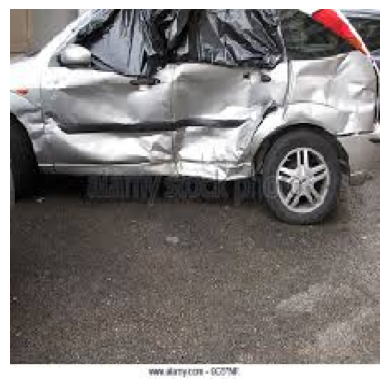

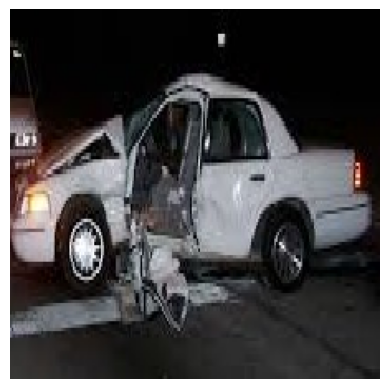

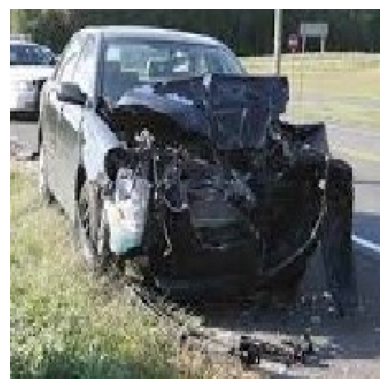

Class: 02-moderate


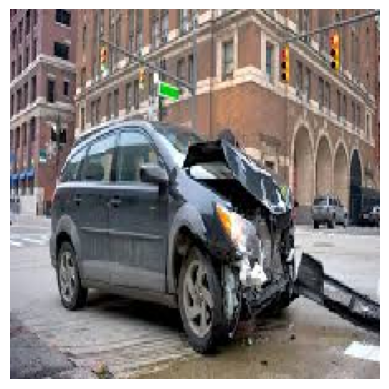

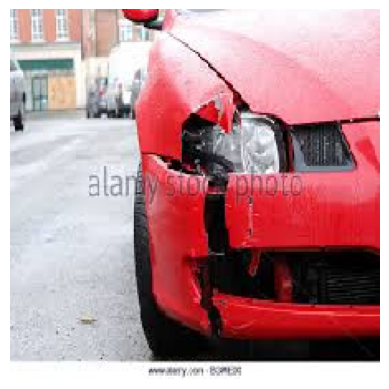

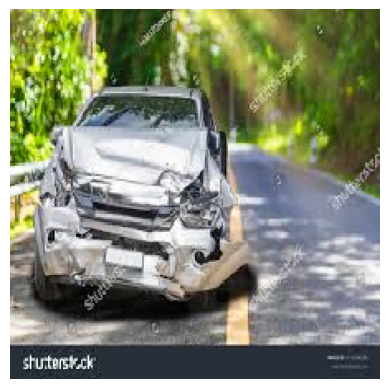

Class: 01-minor


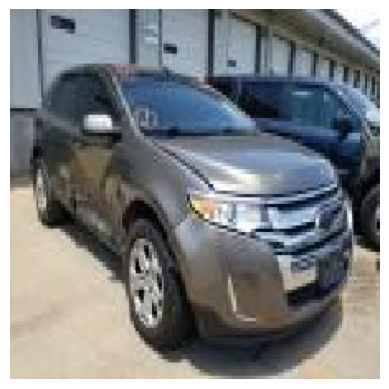

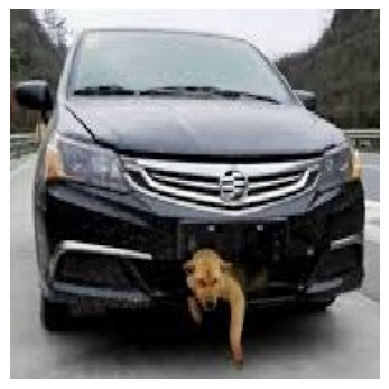

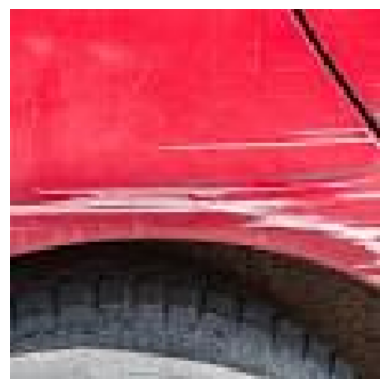

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img


base = '/kaggle/input/car-damage-severity-dataset/data3a/training'

for cls in os.listdir(base):
    print(f"Class: {cls}")
    path = os.path.join(base, cls)
    files = os.listdir(path)[:3] # Just get 3 images
    
    for f in files:
        img = load_img(os.path.join(path, f), target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [62]:
import os
from PIL import Image

base = '/kaggle/input/car-damage-severity-dataset/data3a/training'

first_class = os.listdir(base)[0]
path = os.path.join(base, first_class)

# Print the size of the first 5 images
for f in os.listdir(path)[:5]:
    img = Image.open(os.path.join(path, f))
    print(f"Image Name: {f} | Size: {img.size}")

Image Name: 0349.JPEG | Size: (254, 198)
Image Name: 0364.JPEG | Size: (205, 108)
Image Name: 0125.JPEG | Size: (176, 131)
Image Name: 0223.JPEG | Size: (259, 194)
Image Name: 0030.JPEG | Size: (228, 116)


Pretty clearly, the images are not of  constant size as expected from data scraped from internet.

## Model Building

In [63]:
import tensorflow as tf

# these are the main parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [64]:
#  Create the train dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/car-damage-severity-dataset/data3a/training',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 1383 files belonging to 3 classes.


In [65]:
# similarly for validation, but no shuffle during validation

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/car-damage-severity-dataset/data3a/validation',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 248 files belonging to 3 classes.


In [66]:
# let's look at the class names

class_names = train_ds.class_names
class_names

['01-minor', '02-moderate', '03-severe']

### Baseline Model

In [67]:
# Neural networks work best in [0,1]

normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

In [68]:
# base model: CNN -> pooling -> CNN -> pooling -> flatten -> Dense -> Dense
baseline_model = tf.keras.Sequential([
    normalization_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # probabailties for 3 clases
])

In [69]:
baseline_model.compile(
    loss='sparse_categorical_crossentropy', # for the raw logits
    optimizer='adam',
    metrics=['accuracy']
)

In [73]:
# train the model
baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3359 - loss: 1.1002 - val_accuracy: 0.3589 - val_loss: 1.0949
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3603 - loss: 1.0949 - val_accuracy: 0.3710 - val_loss: 1.0878
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3827 - loss: 1.0851 - val_accuracy: 0.4194 - val_loss: 1.0637
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4501 - loss: 1.0569 - val_accuracy: 0.4960 - val_loss: 1.0264
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4322 - loss: 1.0575 - val_accuracy: 0.4718 - val_loss: 1.0181


In [ ]:
baseline_model.evaluate(val_ds)

#### Clearly, the accuracy is around 43%, and on validation is about 50%.

#### Transfer Learning

In [74]:
# We'll use MobileNET V2 because it balances high-end performance with deployment feasibility.

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [75]:
base_model.trainable = False # We dont wanna train it yet

In [76]:
# get the preprocessing function for MobileNet V2

model = tf.keras.Sequential([
    normalization_layer, # This does the -1 to 1 scaling as expected by mobilenet
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [78]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - accuracy: 0.5131 - loss: 1.3044 - val_accuracy: 0.5847 - val_loss: 1.0109
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6444 - loss: 0.8824 - val_accuracy: 0.6210 - val_loss: 1.1658
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6601 - loss: 1.0173 - val_accuracy: 0.6129 - val_loss: 0.9838
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6980 - loss: 0.8014 - val_accuracy: 0.6048 - val_loss: 0.9589
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6928 - loss: 0.8116 - val_accuracy: 0.6169 - val_loss: 1.2229


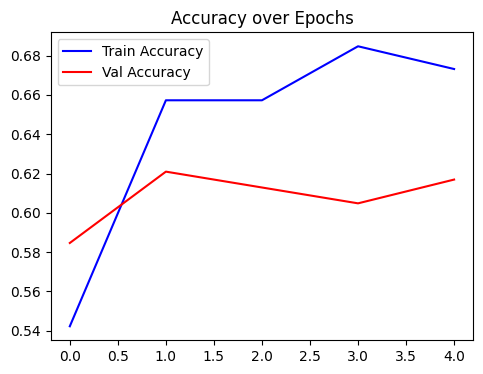

In [79]:
# plot accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.legend()

#### Clearly our model is overfitting!

In [80]:
# try smaller learning rate

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, batch_size=BATCH_SIZE, epochs=5)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - accuracy: 0.7141 - loss: 0.8162 - val_accuracy: 0.6250 - val_loss: 0.9819
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7447 - loss: 0.6035 - val_accuracy: 0.6250 - val_loss: 0.9907
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7386 - loss: 0.6478 - val_accuracy: 0.6371 - val_loss: 0.9786
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7597 - loss: 0.5966 - val_accuracy: 0.6290 - val_loss: 0.9800
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7421 - loss: 0.6339 - val_accuracy: 0.6290 - val_loss: 0.9828


Still the model is overfitting!

### Finetuning the MobileNetV2
Finetuning with auagmentations to reduce overfitting

In [87]:
train_ds.class_names

['01-minor', '02-moderate', '03-severe']

In [90]:
# 1. Define Preprocessing Function clearly
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# 3. Pretrained backbone
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False 

# 4. Full model (Fixed the Lambda layer)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(224, 224, 3)),
    data_augmentation,
    tf.keras.layers.Lambda(preprocess_input, name='preprocessing'), 
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_ds.class_names), activation="softmax")
])

# 5. Train
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 6. Fit with optimized data flow
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 # Increased to 10 for better convergence
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.4114 - loss: 1.3357 - val_accuracy: 0.5726 - val_loss: 0.9438
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4549 - loss: 1.1229 - val_accuracy: 0.6331 - val_loss: 0.8652
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4999 - loss: 0.9838 - val_accuracy: 0.6613 - val_loss: 0.8228
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5612 - loss: 0.9303 - val_accuracy: 0.6411 - val_loss: 0.8009
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5797 - loss: 0.8879 - val_accuracy: 0.6250 - val_loss: 0.8093
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5956 - loss: 0.8622 - val_accuracy: 0.6452 - val_loss: 0.7790
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6091 - loss: 0.8350 - val_accuracy: 0.6452 - val_loss: 0.7615
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6146 - loss: 0.8426 - val_accuracy: 0.6492 - v

In [97]:
# 1. Unfreeze the backbone
base_model.trainable = True

# 2. Re-freeze everything EXCEPT the last 50 layers
# MobileNetV2 has ~154 layers. We only want to tweak the high-level features.
for layer in base_model.layers[:-50]:
    layer.trainable = False

# If you use 1e-4 or 1e-3 here, you will destroy the pre-trained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 4. Train for 15 more epochs
print("Starting Fine-Tuning...")
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Starting Fine-Tuning...
Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7187 - loss: 0.6673 - val_accuracy: 0.7339 - val_loss: 0.5970
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7507 - loss: 0.6198 - val_accuracy: 0.7339 - val_loss: 0.5964
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7228 - loss: 0.6329 - val_accuracy: 0.7419 - val_loss: 0.5960
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6976 - loss: 0.6552 - val_accuracy: 0.7419 - val_loss: 0.5959
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7213 - loss: 0.6585 - val_accuracy: 0.7500 - val_loss: 0.5954
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7349 - loss: 0.6356 - val_accuracy: 0.7460 - val_loss: 0.5949
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7260 - loss: 0.6531 - val_accuracy: 0.7500 - val_loss: 0.5946
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.7260 - loss: 0.6491 

Not the best yet impressive for MobileNet architecture.

In [98]:
# Save the model
model.save("car_damage_model.h5")

In [99]:
# Convert to TFlite for production
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("car_damage_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphntfz7jv/assets


INFO:tensorflow:Assets written to: /tmp/tmphntfz7jv/assets


Saved artifact at '/tmp/tmphntfz7jv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_2469')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135459347459792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031811088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031810512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459347462480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459347462672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031810128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031811280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031811472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031810896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031812432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135459031

W0000 00:00:1768844081.371192      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1768844081.371223      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1768844081.512988      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
